---
title: "GIOZA Case Study: Temperature Analysis"
format:
  html:
    toc: true
    toc-title: Contents
    toc-depth: 4
    code-fold: show
    self-contained: true
jupyter: python3
---

# Loading Packages and Data

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from plotnine import *

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
factory_temp = pd.read_csv('data/temperature.csv')
# convert predictors into proper datatype
factory_temp['at'] = pd.to_datetime(factory_temp['at'])
factory_temp = factory_temp.sort_values(by=['at'], ascending=True).reset_index(drop=True)

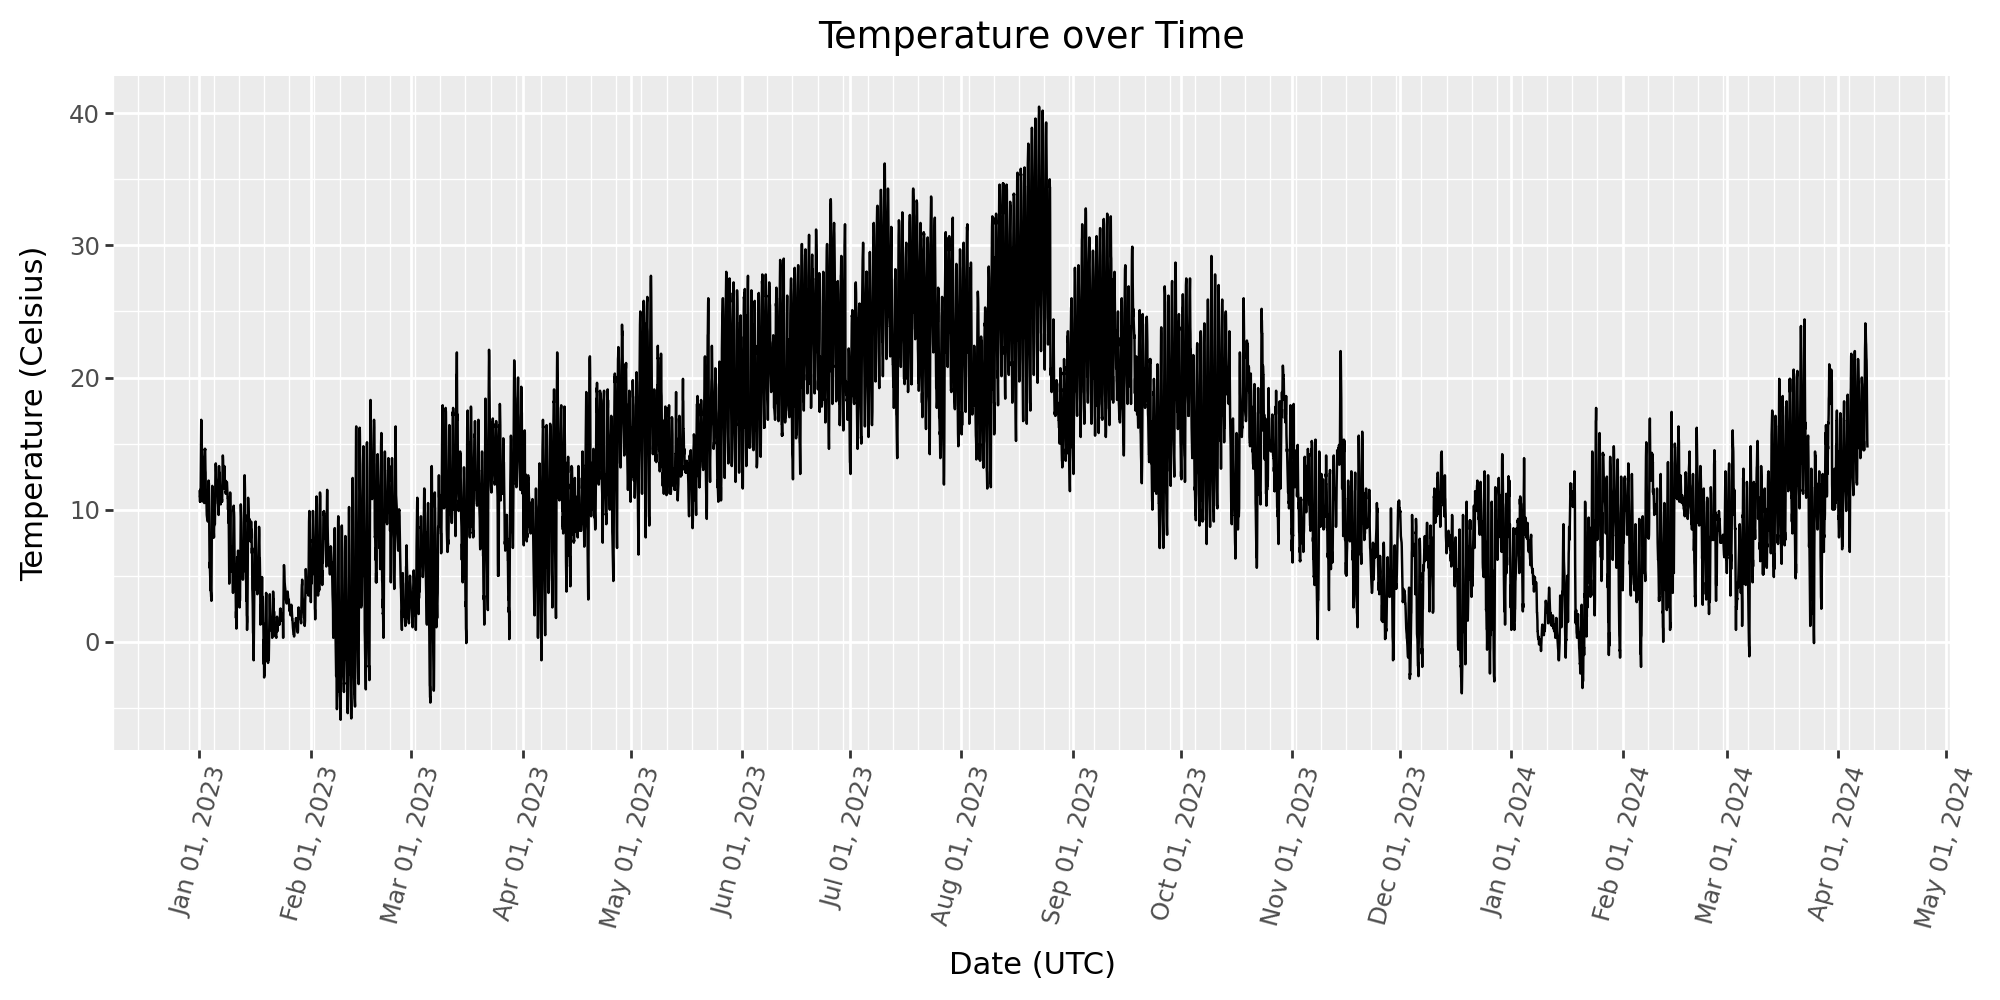

In [3]:
(
    ggplot(factory_temp, aes(x='at', y='T'))
    + geom_line()
    + scale_x_datetime(date_breaks='1 month', date_minor_breaks='1 week', date_labels="%b %d, %Y")
    + theme(figure_size=(10,5), axis_text_x=element_text(angle=75))
    + labs(x = 'Date (UTC)', y = 'Temperature (Celsius)', title = 'Temperature over Time')
)

# Linear Regression

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [5]:
# Function to process the data into # look_back days, # predict days slices
def convert_ts(data, look_back, look_forward):
    datX, datY = [], []
    for i in range(len(data)-look_back-look_forward+1):
        a = data[i:(i+look_back), :]
        datX.append(a)
        datY.append(data[i+look_back+look_forward-1, -1])
    return np.array(datX), np.array(datY).reshape(-1, 1)

In [6]:
data = factory_temp[['T']]
n_train = math.floor(0.9 * len(data))

# apply normalization
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(data[['T']][0:n_train])
test_scaled = scaler.transform(data[['T']][n_train:])
dataset_scaled = np.concatenate((train_scaled, test_scaled), axis=0)

In [7]:
# convert data into lagged data
look_back = 12
look_forward = 3
dataX, dataY = convert_ts(dataset_scaled, look_back, look_forward)

print( dataX.shape, dataY.shape )

dataX = dataX.reshape(-1, look_back)
dataY = dataY.reshape(-1, 1)

# split training / test
trainX = dataX[0:(n_train-look_back), :]
trainY = dataY[0:(n_train-look_back), :]

testX = dataX[(n_train-look_back):, :]
testY = dataY[(n_train-look_back):, :]

print( trainX.shape, trainY.shape )
print( testX.shape, testY.shape )

(11126, 12, 1) (11126, 1)
(10014, 12) (10014, 1)
(1112, 12) (1112, 1)


In [8]:
# fit Linear model
model_linear = LinearRegression()
model_linear.fit(trainX, trainY)

# evaluate model with RMSE
train_preds = scaler.inverse_transform(model_linear.predict(trainX))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(trainY), train_preds ) ) )

test_preds = scaler.inverse_transform(model_linear.predict(testX))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(testY) , test_preds ) ) )

Training Error: 2.258197780360799
Testing Error: 2.2047984562471568


In [9]:
model_linear_coefs = pd.DataFrame(
    model_linear.coef_.reshape(-1,1),
    index=['Lag ' + str(i+1) for i in reversed(range(look_back))], columns=['coef']
)
model_linear_coefs.sort_values(by=['coef'], key=abs, ascending=False)

,coef
Lag 1,1.866513
Lag 2,-0.684324
Lag 12,0.514900
Lag 3,-0.255005
Lag 11,-0.252660
Lag 10,-0.084877
Lag 4,-0.060820
Lag 5,-0.059098
Lag 9,-0.034717
Lag 6,0.009771


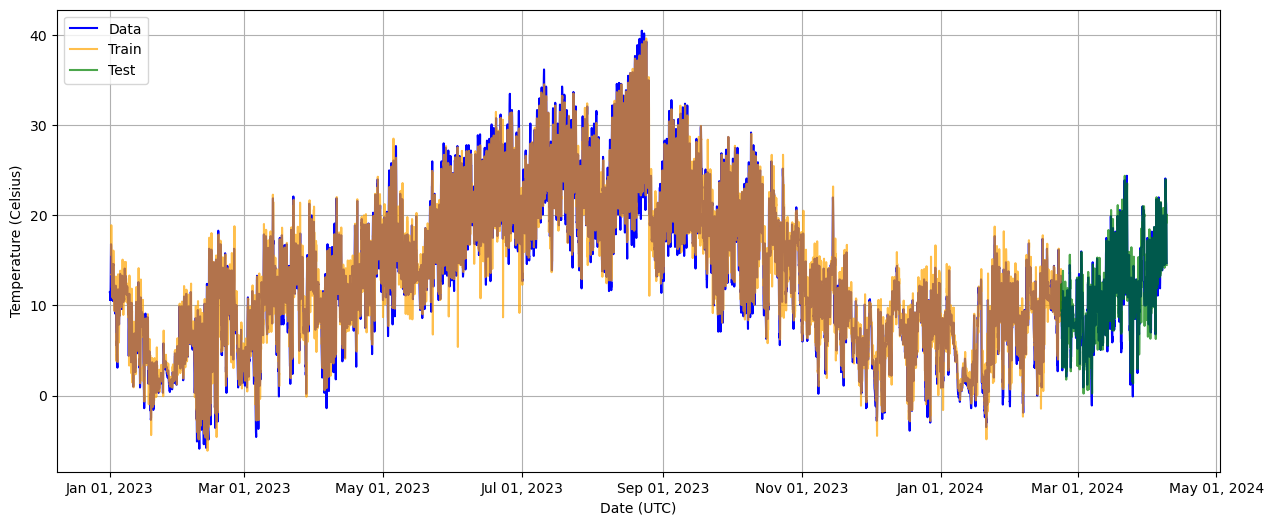

In [10]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.empty_like(factory_temp[['T']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds), :] = train_preds.reshape(-1,1)

test_predict_plot = np.empty_like(factory_temp[['T']])
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+look_forward-1+len(train_preds):look_back+look_forward-1+len(train_preds)+len(test_preds), :] = test_preds.reshape(-1,1)

plt.plot(factory_temp[['at']], factory_temp[['T']], color='blue', label='Data')
plt.plot(factory_temp[['at']], train_predict_plot, color='orange', alpha=0.7, label='Train')
plt.plot(factory_temp[['at']], test_predict_plot, color='green', alpha=0.7, label='Test')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

# Tree-Based Models

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [12]:
# fit decision tree model
model_tree = DecisionTreeRegressor(max_depth=5)
model_tree.fit(trainX, trainY)

# evaluate model with RMSE
train_preds_tree = scaler.inverse_transform(model_tree.predict(trainX).reshape(-1,1))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(trainY), train_preds_tree ) ) )

test_preds_tree = scaler.inverse_transform(model_tree.predict(testX).reshape(-1,1))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(testY) , test_preds_tree ) ) )

Training Error: 2.68636480650455
Testing Error: 2.749478447928708


In [13]:
model_tree_coefs = pd.DataFrame(
    model_tree.feature_importances_,
    index=['Lag ' + str(i+1) for i in reversed(range(look_back))], columns=['coef']
)
model_tree_coefs.sort_values(by=['coef'], key=abs, ascending=False)

,coef
Lag 1,0.959368
Lag 12,0.011402
Lag 5,0.009013
Lag 3,0.007594
Lag 8,0.003875
Lag 4,0.003573
Lag 2,0.002365
Lag 7,0.002143
Lag 11,0.000667
Lag 10,0.000000


In [14]:
# fit random forest model
model_forest = RandomForestRegressor(max_depth=5)
model_forest.fit(trainX, trainY)

# evaluate model with RMSE
train_preds_forest = scaler.inverse_transform(model_forest.predict(trainX).reshape(-1,1))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(trainY), train_preds_forest ) ) )

test_preds_forest = scaler.inverse_transform(model_forest.predict(testX).reshape(-1,1))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(testY) , test_preds_forest ) ) )

Training Error: 2.4641959111040252
Testing Error: 2.508174685399699


In [15]:
model_forest_coefs = pd.DataFrame(
    model_forest.feature_importances_,
    index=['Lag ' + str(i+1) for i in reversed(range(look_back))], columns=['coef']
)
model_forest_coefs.sort_values(by=['coef'], key=abs, ascending=False)

,coef
Lag 1,0.959497
Lag 12,0.009405
Lag 5,0.009058
Lag 3,0.008049
Lag 4,0.005469
Lag 8,0.002575
Lag 2,0.002464
Lag 7,0.001760
Lag 6,0.000916
Lag 11,0.000437


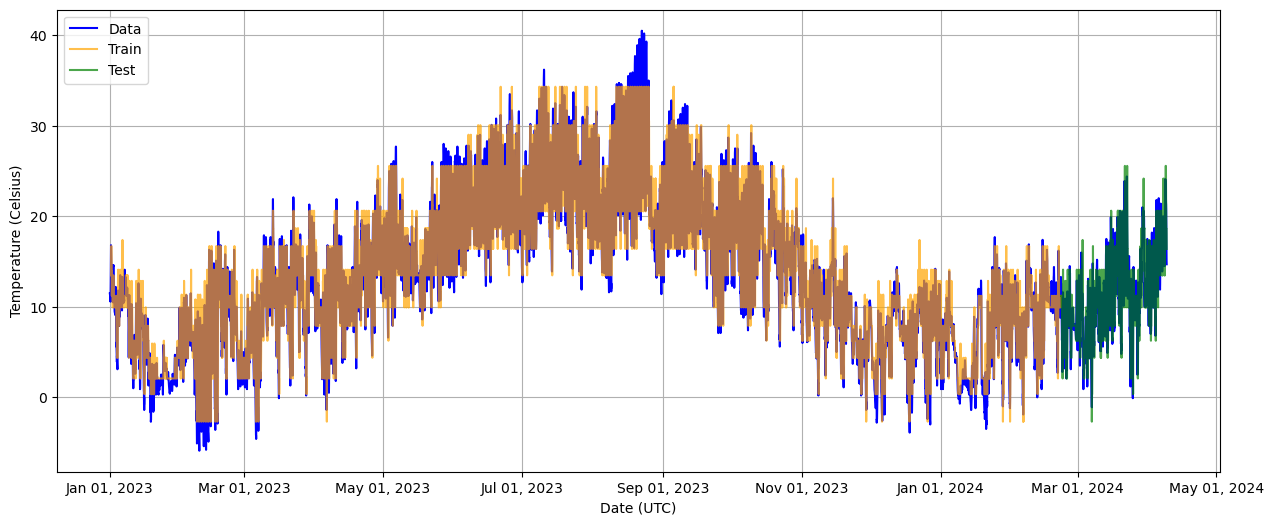

In [16]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.empty_like(factory_temp[['T']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds_tree), :] = train_preds_tree.reshape(-1,1)

test_predict_plot = np.empty_like(factory_temp[['T']])
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+look_forward-1+len(train_preds_tree):look_back+look_forward-1+len(train_preds_tree)+len(test_preds_tree), :] = test_preds_tree.reshape(-1,1)

plt.plot(factory_temp[['at']], factory_temp[['T']], color='blue', label='Data')
plt.plot(factory_temp[['at']], train_predict_plot, color='orange', alpha=0.7, label='Train')
plt.plot(factory_temp[['at']], test_predict_plot, color='green', alpha=0.7, label='Test')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

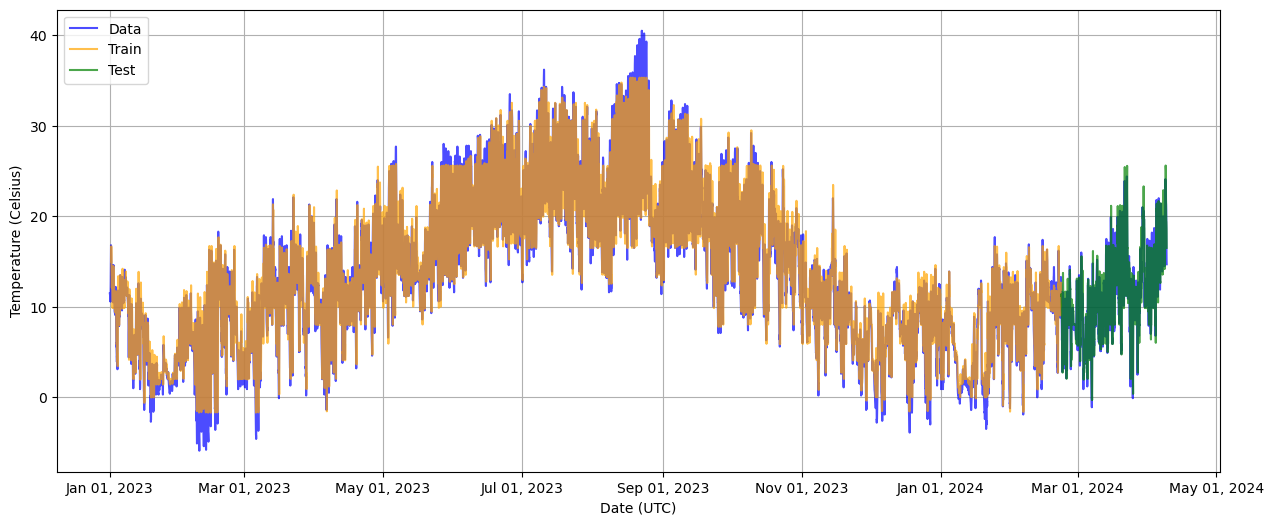

In [17]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.empty_like(factory_temp[['T']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds_forest), :] = train_preds_forest.reshape(-1,1)

test_predict_plot = np.empty_like(factory_temp[['T']])
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+look_forward-1+len(train_preds_forest):look_back+look_forward-1+len(train_preds_forest)+len(test_preds_forest), :] = test_preds_forest.reshape(-1,1)

plt.plot(factory_temp[['at']], factory_temp[['T']], color='blue', alpha=0.7, label='Data')
plt.plot(factory_temp[['at']], train_predict_plot, color='orange', alpha=0.7, label='Train')
plt.plot(factory_temp[['at']], test_predict_plot, color='green', alpha=0.7, label='Test')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

# Recurrent Neural Net

In [18]:
from keras.api.models import Sequential
from keras.api.layers import Dense, LSTM, Dropout

In [19]:
# define model (20-layer LSTM)
def create_lstm():
    model = Sequential()
    model.add(LSTM(20))
    model.add(Dense(20))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    return model

In [20]:
# define model, criterion, and optimizer
model_rnn = create_lstm()
model_rnn.compile(optimizer='adam', loss='mean_squared_error')

# train model
model_hist = model_rnn.fit(
    trainX.reshape(-1, look_back, 1), trainY.reshape(-1, 1), epochs=50, batch_size=24*30
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1534
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0273 
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195 
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165 
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 
Epoch 13/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 
Epoch 14/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 
Epoch 15/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 
Epoch 1

In [21]:
# evaluate model with RMSE
train_preds_rnn = scaler.inverse_transform(model_rnn.predict(trainX))
print('Training Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(trainY), train_preds_rnn ) ) )

test_preds_rnn = scaler.inverse_transform(model_rnn.predict(testX))
print('Testing Error:', math.sqrt( metrics.mean_squared_error( scaler.inverse_transform(testY) , test_preds_rnn ) ) )

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
Training Error: 3.273298769339905
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
Testing Error: 2.9339257658272966


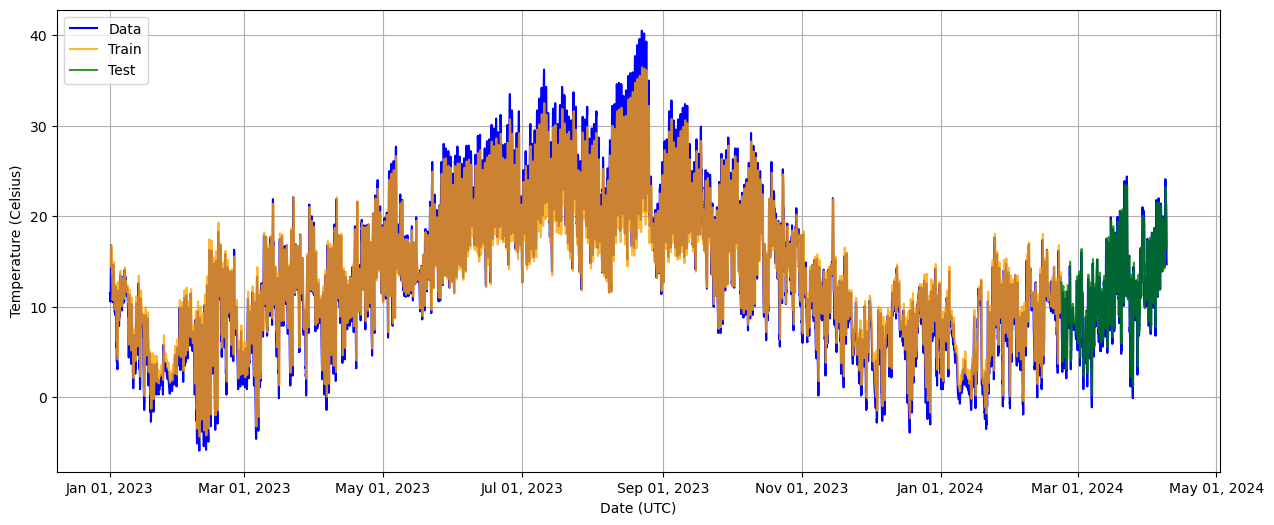

In [22]:
fig, ax = plt.subplots(figsize=(15,6))

train_predict_plot = np.empty_like(factory_temp[['T']])
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back+look_forward-1:look_back+look_forward-1+len(train_preds_rnn), :] = train_preds_rnn.reshape(-1,1)

test_predict_plot = np.empty_like(factory_temp[['T']])
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+look_forward-1+len(train_preds_rnn):look_back+look_forward-1+len(train_preds_rnn)+len(test_preds_rnn), :] = test_preds_rnn.reshape(-1,1)

plt.plot(factory_temp[['at']], factory_temp[['T']], color='blue', label='Data')
plt.plot(factory_temp[['at']], train_predict_plot, color='orange', alpha=0.8, label='Train')
plt.plot(factory_temp[['at']], test_predict_plot, color='green', alpha=0.8, label='Test')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %Y'))
plt.legend(loc='upper left')
plt.xlabel('Date (UTC)')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()